<a href="https://colab.research.google.com/github/telecombcn-dl/2018-dlai-team2/blob/master/Variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoecoder (VAE)**

All necessary liberaries are imported.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from keras import backend as K

from google.colab import files
import cv2
import copy

import random

Using TensorFlow backend.


## VAE on MNIST dataset

The MNIST dataset is downloaded and the data are normalized.

In [0]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Varaiational AutoEncoder model 

In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# CNN
# network parameters
input_shape = (image_size, image_size, 1)
latent_dim = 2

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(filters=16,kernel_size=3,activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=32,kernel_size=3,activation='relu', strides=2, padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(x)

outputs = Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 16)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 7, 7, 32)     4640        conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 1568)         0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
dense_5 (D

We define a loss function

In [0]:
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

and train the neural network.

In [0]:
log = vae.fit(x_train,
        epochs=100,
        batch_size=128,
        validation_data=(x_test, None),
        verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 7s - loss: 205.9756 - val_loss: 176.5596
Epoch 2/100
 - 7s - loss: 172.8848 - val_loss: 170.3002
Epoch 3/100
 - 7s - loss: 167.6647 - val_loss: 166.4019
Epoch 4/100
 - 7s - loss: 164.6036 - val_loss: 163.4468
Epoch 5/100
 - 7s - loss: 162.3730 - val_loss: 160.5410
Epoch 6/100
 - 7s - loss: 160.6782 - val_loss: 160.1780
Epoch 7/100
 - 7s - loss: 159.4956 - val_loss: 158.8222
Epoch 8/100
 - 7s - loss: 158.5188 - val_loss: 156.9962
Epoch 9/100
 - 7s - loss: 157.6559 - val_loss: 158.4668
Epoch 10/100
 - 7s - loss: 156.9290 - val_loss: 155.9860
Epoch 11/100
 - 7s - loss: 156.2781 - val_loss: 155.3462
Epoch 12/100
 - 7s - loss: 155.7204 - val_loss: 158.7398
Epoch 13/100
 - 7s - loss: 155.1554 - val_loss: 157.0983
Epoch 14/100
 - 7s - loss: 154.7578 - val_loss: 154.7634
Epoch 15/100
 - 7s - loss: 154.2670 - val_loss: 154.3509
Epoch 16/100
 - 7s - loss: 153.9235 - val_loss: 155.0869
Epoch 17/100
 - 7s - loss: 153.5344 - val_loss:

Now, the loss and the validation loss curves are depicted.

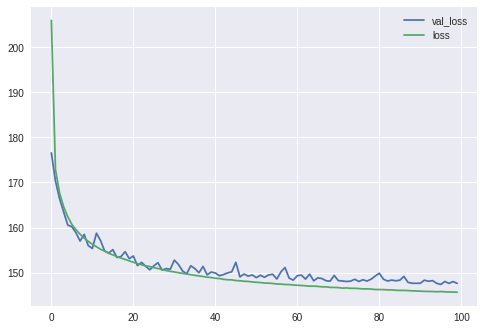

In [0]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

Since the 2-dimensional latent space is used, it can be nicely visualized.

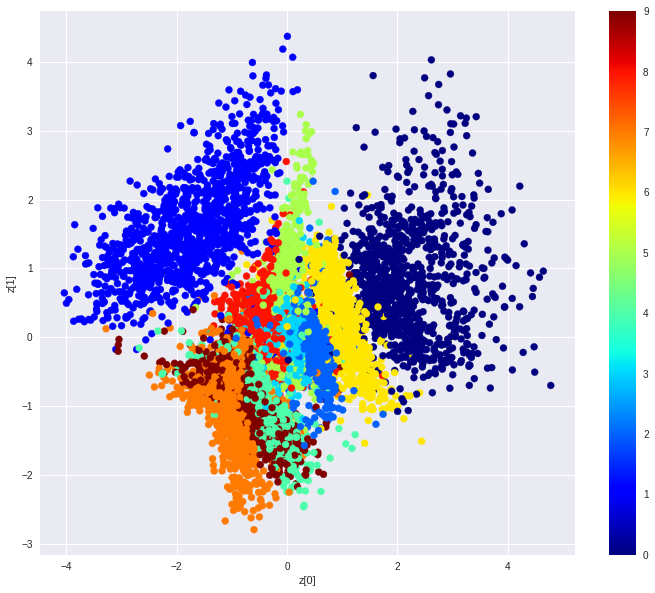

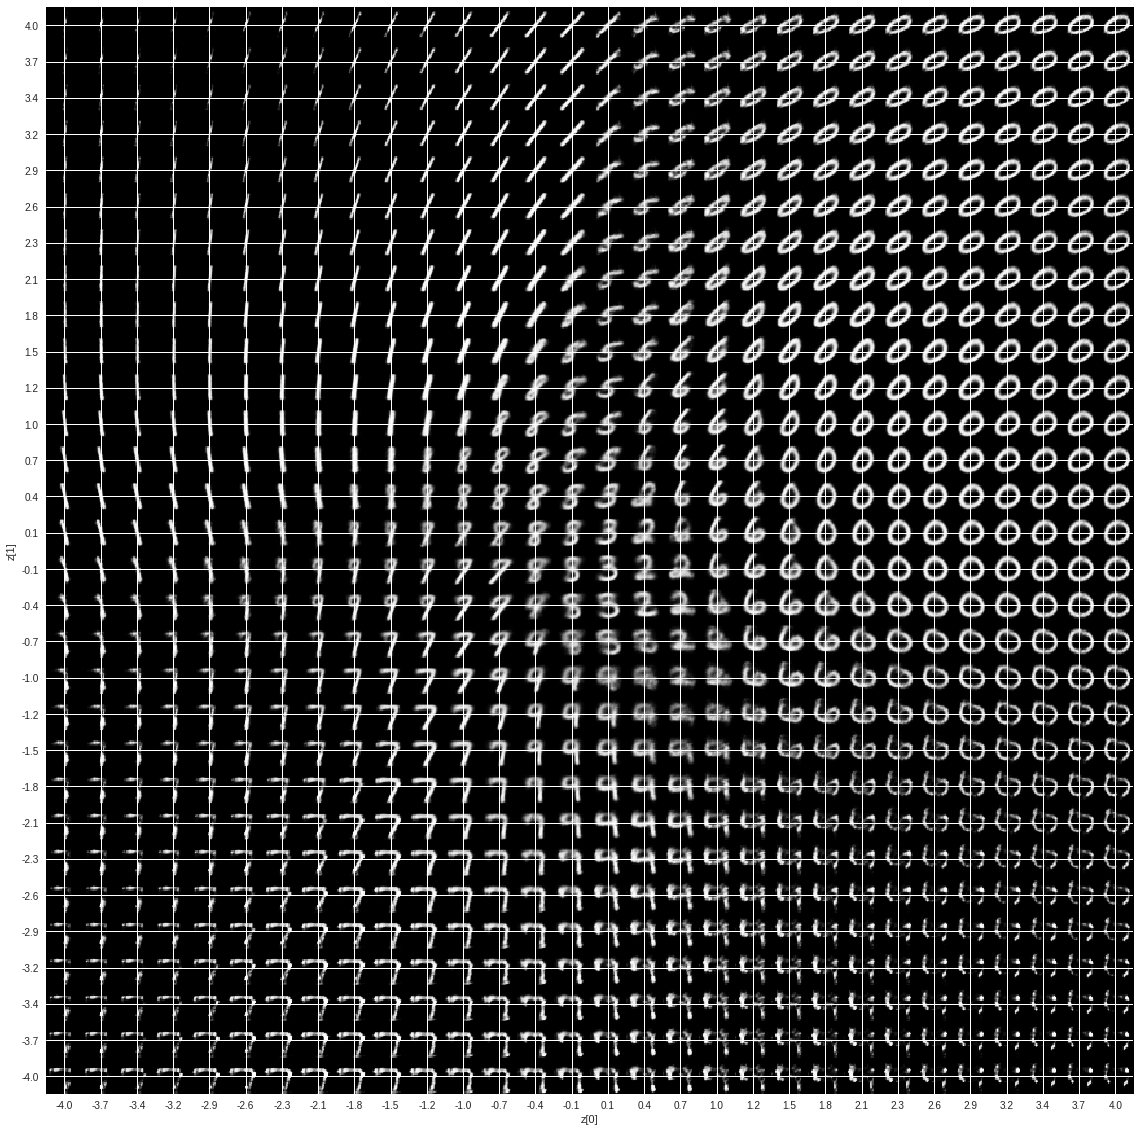

In [0]:
model_name="vae_mnist"
encoder, decoder = models
x_test, y_test = data
os.makedirs(model_name, exist_ok=True)

filename = os.path.join(model_name, "vae_mean.png")
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = encoder.predict(x_test,batch_size=128)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig(filename)
plt.show()

filename = os.path.join(model_name, "digits_over_latent.png")
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.savefig(filename)
plt.show()

Now, let´s cut off the encoder and generate pictures only by giving the decoder 2 random numbers.

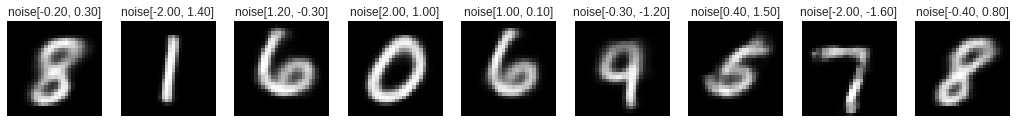

In [0]:
# Plot 10 examples when feeding the decoder with random samples from the 
# latent two-dimensional space
n = 10 
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # Generate a random sample with values between -4.0 and 4.0
    z_sample = np.array([[random.randint(-20,20)/10, random.randint(-20,20)/10]])
    # Feed decoder
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    
    # Plot one example
    ax = plt.subplot(1, n, i)
    plt.imshow(digit)
    plt.title("noise[%.2f, %.2f]" %(z_sample[0,0], z_sample[0,1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## VAE on Anime dataset

### Dataset and VAE architecture

The Anime dataset is downloaded and training data (x_train_anime) and validation data (x_val_anime) are classified.

In [13]:
!wget http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
!unzip -qq animeface-character-dataset.zip

--2018-12-11 16:50:27--  http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
Resolving www.nurs.or.jp (www.nurs.or.jp)... 54.187.126.238
Connecting to www.nurs.or.jp (www.nurs.or.jp)|54.187.126.238|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592335393 (565M) [application/zip]
Saving to: ‘animeface-character-dataset.zip.1’

animeface-character 100%[===================>] 564.89M   130MB/s    in 4.9s    

2018-12-11 16:50:32 (115 MB/s) - ‘animeface-character-dataset.zip.1’ saved [592335393/592335393]

replace animeface-character-dataset/index.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
x_train_anime = []
x_val_anime = []


directories = os.listdir('animeface-character-dataset/thumb/')
for directory in directories:
  dir_path = 'animeface-character-dataset/thumb/'+directory
  num_fil = 0
  num_train = 0
  num_val = 0
  if os.path.isdir(dir_path):
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        num_fil += 1
    num_train = int(round(num_fil*0.7))
    num_val = int(round((num_fil-num_train)*0.5))
    i = 0
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        filepath = dir_path+"/"+filename
        if i<num_train:
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_train_anime.append(img)
        elif i<(num_train+num_val):
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_val_anime.append(img)
        i += 1
x_train_anime = np.array(x_train_anime)
x_val_anime = np.array(x_val_anime)

Normalization is performed and size of the pictures is changed.

In [0]:
# Normalization
max_value = float(max(x_train_anime.max(),x_val_anime.max()))
x_train_anime = x_train_anime.astype('float32') / max_value
x_val_anime = x_val_anime.astype('float32') / max_value
# Size change
x_train_anime = np.reshape(x_train_anime, (len(x_train_anime), 64, 64, 3))
x_val_anime = np.reshape(x_val_anime, (len(x_val_anime), 64, 64, 3))

Varaiational AutoEncoder model 
- performed for latent space dimension of


1.   z = 2
2.   z = 5
3.   z = 100







    

In [75]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# CNN
# network parameters
input_shape = (64, 64, 3)
latent_dim = 100

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(16, (3, 3),activation='relu', strides=2, padding='same')(x)
x = Conv2D(32, (3, 3),activation='relu', strides=2, padding='same')(x)


# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(latent_dim*5,activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', strides=2, padding='same')(x)
outputs = Conv2DTranspose(filters=3, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 16, 16, 32)   4640        conv2d_17[0][0]                  
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 8192)         0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
dense_17 (

Loss function is defined.

In [0]:
models = (encoder, decoder)
image_size = 64

# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')


Again, we train the neural network.

In [77]:
log_anime = vae.fit(x_train_anime,
        epochs=100,
        batch_size=128,
        validation_data=(x_val_anime, None),
        verbose=2)

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
 - 6s - loss: 2639.6779 - val_loss: 2605.6788
Epoch 2/100
 - 4s - loss: 2535.5000 - val_loss: 2505.1876
Epoch 3/100
 - 4s - loss: 2479.3609 - val_loss: 2433.3034
Epoch 4/100
 - 4s - loss: 2443.6871 - val_loss: 2415.6006
Epoch 5/100
 - 4s - loss: 2419.5562 - val_loss: 2387.0543
Epoch 6/100
 - 4s - loss: 2400.8543 - val_loss: 2383.0045
Epoch 7/100
 - 4s - loss: 2381.2926 - val_loss: 2364.3959
Epoch 8/100
 - 4s - loss: 2362.5195 - val_loss: 2341.0163
Epoch 9/100
 - 4s - loss: 2349.1649 - val_loss: 2328.7078
Epoch 10/100
 - 4s - loss: 2337.6308 - val_loss: 2340.6823
Epoch 11/100
 - 4s - loss: 2329.9276 - val_loss: 2318.8669
Epoch 12/100
 - 4s - loss: 2322.4758 - val_loss: 2313.6788
Epoch 13/100
 - 4s - loss: 2316.8019 - val_loss: 2304.8316
Epoch 14/100
 - 4s - loss: 2311.0086 - val_loss: 2298.0785
Epoch 15/100
 - 4s - loss: 2306.0121 - val_loss: 2298.3696
Epoch 16/100
 - 4s - loss: 2299.3529 - val_loss: 2295.7417
Epoch 17/100
 - 

### Results

Finally, for each latent space dimension:

*   the loss and the validation loss curves are plotted,

*   random values are given to the decoder and ten obtained pictures are depicted.







#### Dimension of latent space z = 2

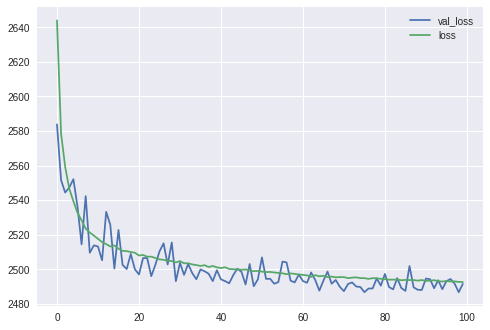

In [71]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log_anime.history.items()]
plt.legend()
plt.show()

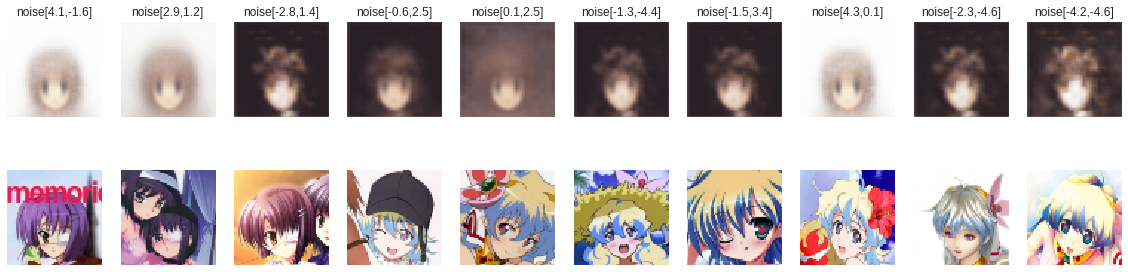

In [74]:
# Plot 10 examples when feeding the decoder with random samples from the 
# latent 2-dimensional space
n = 10

plt.figure(figsize=(22, 5))
for i in range(1,n+1):
    # Generate a random sample with values between -5.0 and 5.0
    z_sample = np.array([[random.randint(-50,50)/10, random.randint(-50,50)/10]])
    # Feed decoder
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(64, 64, 3)
    
    # Plot pictures obtained by feedig the decoder with random values
    ax = plt.subplot(2, n+1, i)
    plt.imshow(digit)
    plt.title("noise[%.1f,%.1f]" %(z_sample[0,0], z_sample[0,1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot samples of original original pictures
    ax2 = plt.subplot(2, n+1, i+n+1)
    plt.imshow(x_val_anime[i+3].reshape(64,64,3))
    plt.gray()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
plt.show()

#### Dimension of latent space z = 5

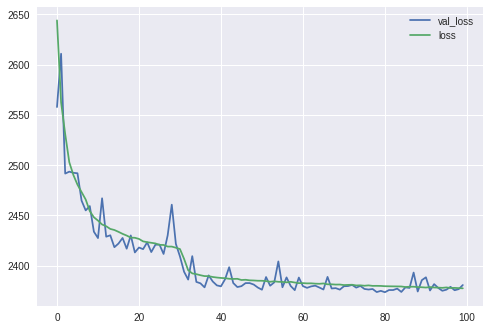

In [59]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log_anime.history.items()]
plt.legend()
plt.show()

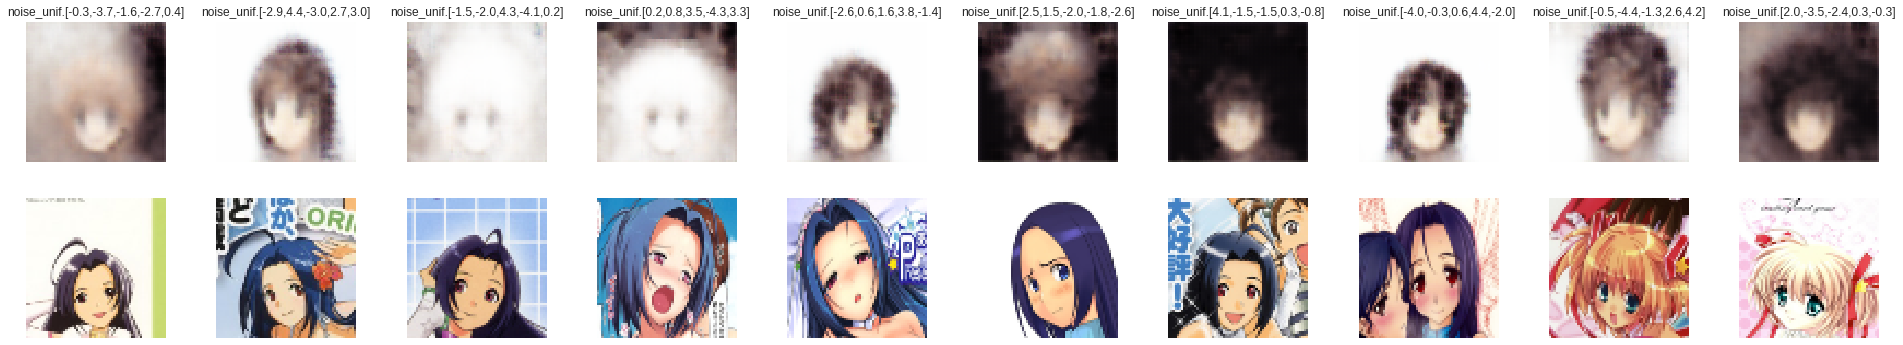

In [63]:
# Plot 10 examples when feeding the decoder with random samples from the 
# latent 5-dimensional space
n = 10

plt.figure(figsize=(29, 5))
for i in range(1,n+1):
    # Generate a random sample with values between -4.5 and 4.5
    z_sample = np.array([[random.randint(-45,45)/10, random.randint(-45,45)/10,random.randint(-45,45)/10,random.randint(-45,45)/10,random.randint(-45,45)/10]])
   
    # Feed decoder
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(64, 64, 3)
    
    # Plot pictures obtained by feedig the decoder with random values
    ax = plt.subplot(2, n+1, i)
    plt.tight_layout()
    plt.imshow(digit)
    plt.title("noise_unif.[%.1f,%.1f,%.1f,%.1f,%.1f]" %(z_sample[0,0], z_sample[0,1],z_sample[0,2],z_sample[0,3],z_sample[0,4]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # plot samples of original original pictures
    ax2 = plt.subplot(2, n+1, i+n+1)
    
    plt.imshow(x_val_anime[i+300].reshape(64,64,3))
    plt.gray()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
plt.show()

#### Dimension of latent space z = 100

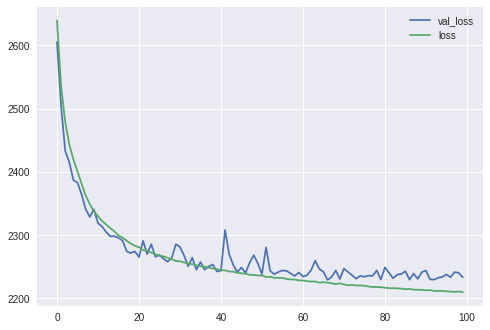

In [78]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log_anime.history.items()]
plt.legend()
plt.show()

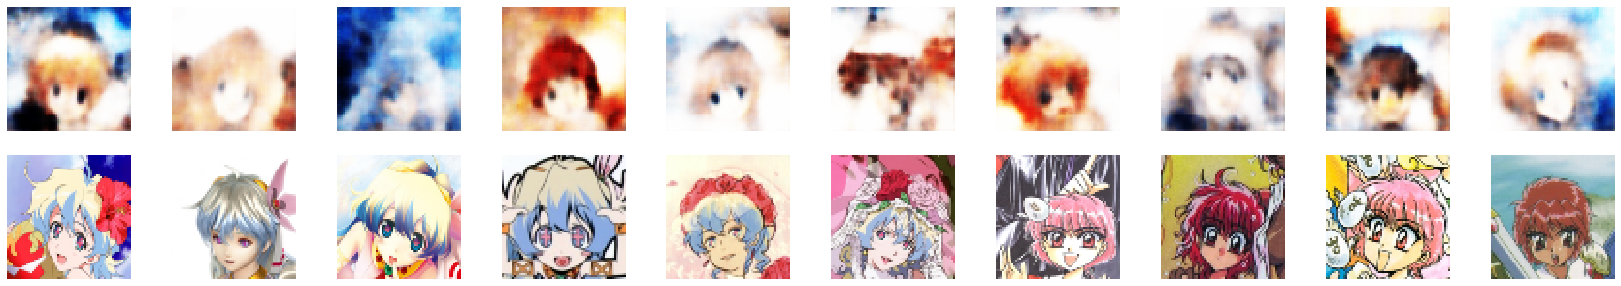

In [206]:
# Plot 10 examples when feeding the decoder with random samples from the 
# latent 100-dimensional space
n = 10
num = latent_dim

z_sample = np.array([[0 for x in range(num)]],dtype='f')
z_sample.astype(float)
plt.figure(figsize=(32, 5))
for i in range(1,n+1):
    # Generate a random sample with values between -4.5 and 4.5
    for j in range (0,num):
      z_sample[0][j] = random.randint(-45,45)/10
 
   
  # Feed decoder
    x_decoded = decoder.predict(z_sample)
    anime = x_decoded[0].reshape(64, 64, 3)
    
    # Plot pictures obtained by feedig the decoder with random values
    ax = plt.subplot(2, n+1, i)
    
    plt.imshow(anime)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot samples of original original pictures
    ax2 = plt.subplot(2, n+1, i+n+1)
    
    plt.imshow(x_val_anime[i+10].reshape(64,64,3))
    plt.gray()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
plt.show()


    